<a href="https://colab.research.google.com/github/littlecl42/AAI-511-03_Group2/blob/main/notebooks/GroupProject_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Final Team Project Introduction
### Introduction

Music is a form of art that is ubiquitous and has a rich history. Different composers have created music with their unique styles and compositions. However, identifying the composer of a particular piece of music can be a challenging task, especially for novice musicians or listeners. The proposed project aims to use deep learning techniques to identify the composer of a given piece of music accurately.

### Objective

The primary objective of this project is to develop a deep learning model that can predict the composer of a given musical score accurately. The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).

### Project Timeline

- Module 2 (by the end of Week 2): The course instructor will group students into teams of two to three members. Canvas, USD Email, or Slack can be used to find prospective team members.
- Module 4 (by the end of Week 4): Each team's representative will need to submit the "Team Project Status Update Form."
- Module 7 (by the end of Week 7): Each team should submit deliverables for the course project in the final week:

>1.  Project Report
>1. Project Notebook

It is critical to note that no extensions will be given for any of the final projects' due dates for any reason, and final projects submitted after the final due date will not be graded.
Dataset

The project will use a dataset consisting of musical scores from various composers. The dataset Download datasetwill contain MIDI files and sheet music of compositions from well-known classical composers like Bach, Beethoven, Chopin, Mozart, Schubert, etc. The dataset should be labeled with the name of the composer for each score.

### Dataset
The project will use a dataset consisting of musical scores from various composers. Download the dataset from Kaggle websiteLinks to an external site..

The dataset contains the midi files of compositions from well-known classical composers like Bach, Beethoven, Chopin, and Mozart. The dataset should be labeled with the name of the composer for each score. Please only do your prediction only for below composers, therefore you need to select the required composers from the given dataset above.

>1. Bach
>1. Beethoven
>1. Chopin
>1. Mozart

### Methodology

The proposed project will be implemented using the following steps:

1. Data Collection: Data is collected and provided to you.
1. Data Pre-processing: Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.
1. Feature Extraction: Extract features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.
1. Model Building: Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.
1. Model Training: Train the deep learning model using the pre-processed and feature-extracted data.
1. Model Evaluation: Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.
1. Model Optimization: Optimize the deep learning model by fine-tuning hyperparameters.

### Deliverables

1. Project Report: A comprehensive documentation/report that describes the methodology, data pre-processing steps, feature extraction techniques, model architecture, and training process for reproducibility and future reference. Write your technical report in APA 7 style (here is a Sample Professional Paper format to follow). Please submit the report in PDF format and use the File naming convention DeliverableName-TeamNumber.pdf; for example, Project_Report-Team1.pdf

Your report should:
contain a reference list that includes any external sources, libraries, or frameworks used during the project, including proper citations or acknowledgments.

include a concluding section or markdown cell that summarizes the project, highlights key findings, and suggests any potential future improvements or extensions to the work.

2. Project Notebook: A Jupyter Notebook file (.ipynb) that contains the entire project code, including data pre-processing, feature extraction, model building, training, evaluation, and any additional analysis or visualizations performed during the project.

This deliverable will be exported from a Jupyter Notebook and submitted as a PDF or HTML file.

### Conclusion

The proposed project aims to use deep learning techniques to accurately predict the composer of a given musical score. The project will be implemented using LSTM and CNN architectures and will involve data pre-processing, feature extraction, model building, training, and evaluation. The final model can be used by novice musicians, listeners, and music enthusiasts to identify the composer of a musical piece accurately.

### Power Usage for this Project

You can use Google Colab GPU and TPU in case you need more computation power. Change your runtime in Google Colab notebook to GPU or TPU.
Another option is to buy the subscription in case you need more computational power (recommended).

Please follow this link to do so: Google Colab Pro+.
NOTE: Team members may not get the same grade on the Final Team Project, depending on each team member's level of contribution.

To understand how your work will be assessed, view the assignment rubric on the Final Team Project page.



In [ ]:
!pip install pretty_midi


In [ ]:
# Required libs for the project
import kagglehub
import pretty_midi
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import re
import difflib

In [ ]:
# Download latest version
path = kagglehub.dataset_download("blanderbuss/midi-classic-music")
print("Path to dataset files:", path)
midi_path = path

Path to dataset files: /kaggle/input/midi-classic-music


In [ ]:
known_composers = [
    "Bach", "Mozart", "Beethoven", "Chopin", "Tchaikovsky", "Handel", "Schubert",
    "Haydn", "Brahms", "Liszt", "Mendelssohn", "Debussy", "Ravel", "Grieg", "Dvorak",
    "Vivaldi", "Stravinsky", "Rachmaninoff", "Mahler", "Shostakovich", "Alkan", "Albeniz",
    "Ambroise", "Arensky", "Arndt", "Bacewitz"
]

def load_midi_files(directory):
    midi_data = []
    bad_files = []  # Track bad files
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith((".mid", ".midi")):
                try:
                    full_path = os.path.join(root, file)
                    midi = pretty_midi.PrettyMIDI(full_path)
                    midi_data.append((full_path, file, midi))
                except Exception:
                    bad_files.append(file)
                    continue
    return midi_data, bad_files

In [ ]:
def extract_composer_from_path(full_path):
    parts = os.path.normpath(full_path).split(os.sep)
    for part in reversed(parts[:-1]):  # Exclude filename
        for composer in known_composers:
            if composer.lower() in part.lower():
                return composer
    return "Unknown"

In [ ]:
def extract_features(midi_dataset):
    rows = []
    for full_path, filename, midi in midi_dataset:
        try:
            duration = midi.get_end_time()
            num_instruments = len(midi.instruments)

            tempo_changes = midi.get_tempo_changes()
            tempo = float(np.mean(tempo_changes[1])) if len(tempo_changes[1]) > 0 else np.nan

            notes = [note.pitch for instrument in midi.instruments for note in instrument.notes if not instrument.is_drum]
            avg_pitch = np.mean(notes) if notes else np.nan
            note_density = len(notes) / duration if duration > 0 else 0

            composer = extract_composer_from_path(full_path)

            rows.append({
                "filename": filename,
                "composer": composer,
                "duration": duration,
                "num_instruments": num_instruments,
                "tempo": tempo,
                "avg_pitch": avg_pitch,
                "note_density": note_density
            })

        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue

    return pd.DataFrame(rows)

In [ ]:
midi_dataset, bad_files = load_midi_files(midi_path)
print(f"Loaded {len(midi_dataset)} good MIDI files.")
print(f"Skipped {len(bad_files)} broken files.")

/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Loaded 4625 good MIDI files.
Skipped 87 broken files.


In [ ]:
df = extract_features(midi_dataset)

In [ ]:
composer_counts = df["composer"].value_counts()
print(composer_counts)

composer
Unknown         2494
Bach            1024
Mozart           256
Beethoven        212
Chopin           136
Schubert         124
Vivaldi          107
Haydn             91
Brahms            60
Alkan             20
Liszt             17
Ravel             13
Shostakovich      13
Grieg             13
Debussy           13
Mendelssohn        9
Dvorak             7
Bacewitz           4
Arensky            4
Ambroise           4
Arndt              2
Tchaikovsky        1
Handel             1
Name: count, dtype: int64


In [ ]:
# Keep only the selected composers
df = df[df["composer"].isin(["Bach", "Beethoven", "Chopin", "Mozart"])].reset_index(drop=True)

In [ ]:
composer_counts = df["composer"].value_counts()
print(composer_counts)

composer
Bach         1024
Mozart        256
Beethoven     212
Chopin        136
Name: count, dtype: int64


In [ ]:
df.head()

,filename,composer,duration,num_instruments,tempo,avg_pitch,note_density
0,Bwv0560 Short Prelude and Fugue n8 (Spurious).mid,Bach,241.097220,3,68.500098,62.635664,6.466271
1,Bwv0529 Sonate en trio n5.mid,Bach,919.469837,3,65.000026,66.001849,7.057328
2,Bwv0992 Capriccio.mid,Bach,494.218750,12,120.000000,63.030814,6.238128
3,Bwv0530 Sonate en trio n6.mid,Bach,996.201692,3,57.857184,65.485542,6.317998
4,Bwv0594 Vivaldi Concerto Arrangement RV208.mid,Bach,1121.868510,3,81.154444,63.633112,8.722056


In [ ]:
# Show basic summary of the data
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1628 entries, 0 to 1627
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   filename         1628 non-null   object 
 1   composer         1628 non-null   object 
 2   duration         1628 non-null   float64
 3   num_instruments  1628 non-null   int64  
 4   tempo            1628 non-null   float64
 5   avg_pitch        1628 non-null   float64
 6   note_density     1628 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 89.2+ KB


,duration,num_instruments,tempo,avg_pitch,note_density
count,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000
mean,245.948097,5.281327,98.781215,62.955368,10.875353
std,318.735113,4.507533,37.268216,3.022680,7.435646
min,17.500000,1.000000,20.563971,50.678211,0.595751
25%,50.998750,2.000000,76.028068,61.090605,6.435134
50%,135.512820,4.000000,96.000000,62.871296,8.167090
75%,327.181909,6.000000,114.999998,64.747720,12.433284
max,5209.310787,40.000000,289.999859,75.268293,51.308206


/tmp/ipython-input-35-3147984237.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="composer", palette='Set2')


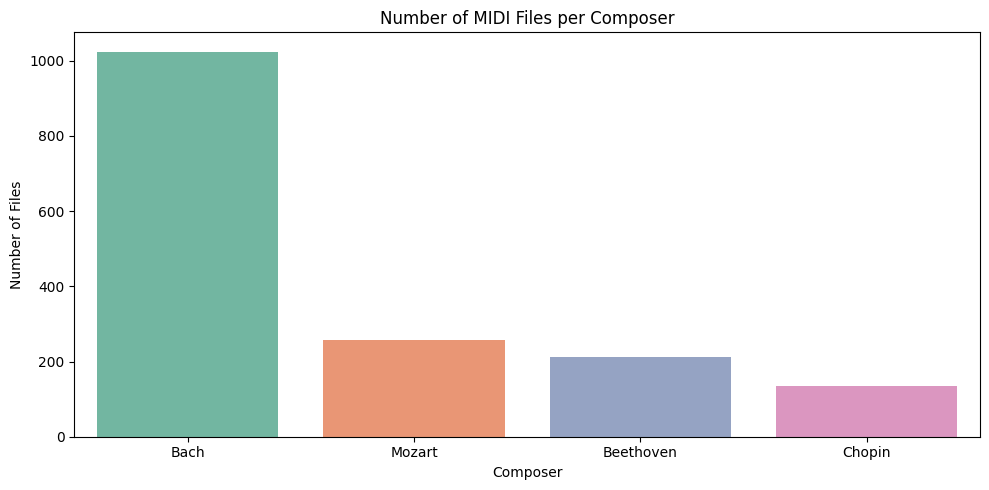

In [ ]:
# Number of MIDI files per composer
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="composer", palette='Set2')
plt.title("Number of MIDI Files per Composer")
plt.xlabel("Composer")
plt.ylabel("Number of Files")
plt.tight_layout()
plt.show()

/tmp/ipython-input-36-2580003255.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="composer", y="duration", palette='Set2')


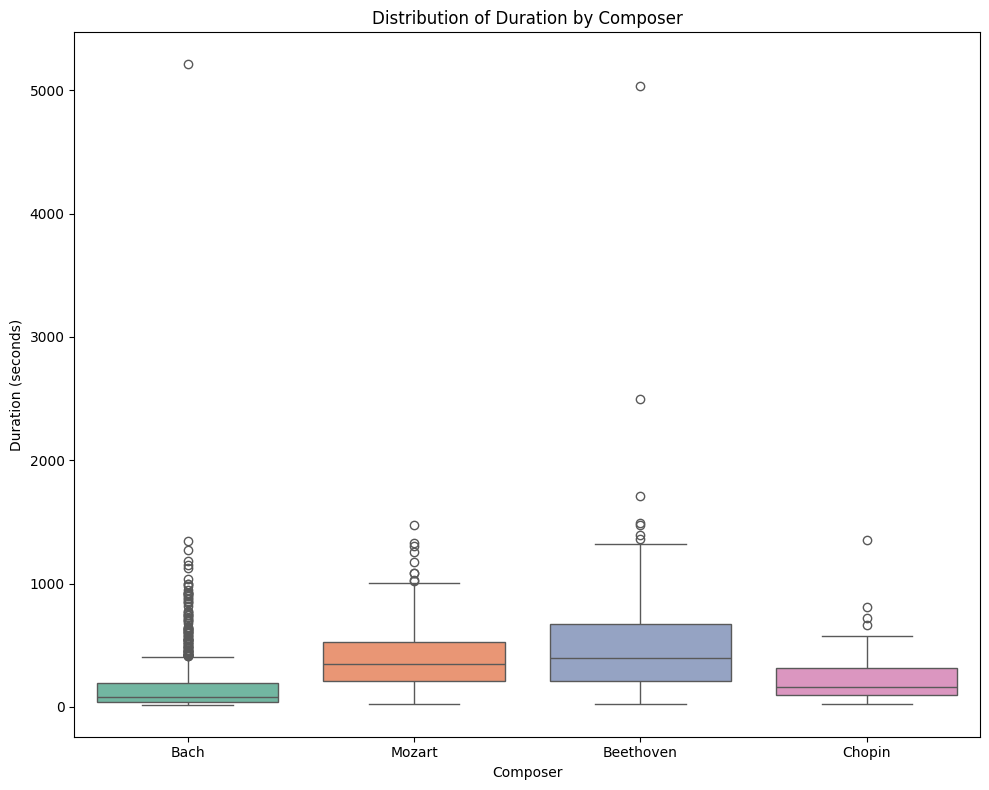

In [ ]:
# Distribution of Duration by Composer
plt.figure(figsize=(10, 8))
sns.boxplot(data=df, x="composer", y="duration", palette='Set2')
plt.title("Distribution of Duration by Composer")
plt.xlabel("Composer")
plt.ylabel("Duration (seconds)")
plt.tight_layout()
plt.show()


/tmp/ipython-input-37-422398147.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="composer", y="num_instruments", inner="quartile", palette="Set2")


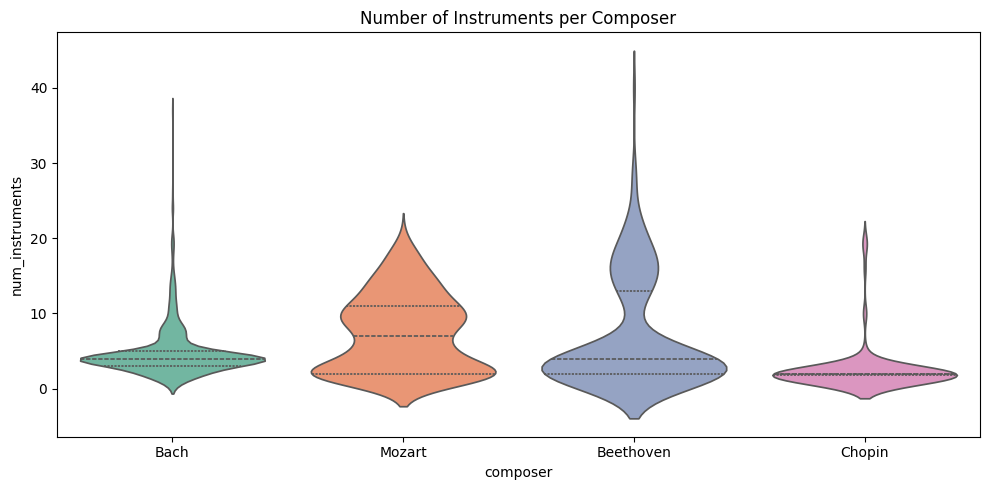

In [ ]:
# Number of Instruments per Composer
plt.figure(figsize=(10, 5))
sns.violinplot(data=df, x="composer", y="num_instruments", inner="quartile", palette="Set2")
plt.title("Number of Instruments per Composer")
plt.tight_layout()
plt.show()

/tmp/ipython-input-38-4130322748.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="composer", y="note_density", palette="Set2")


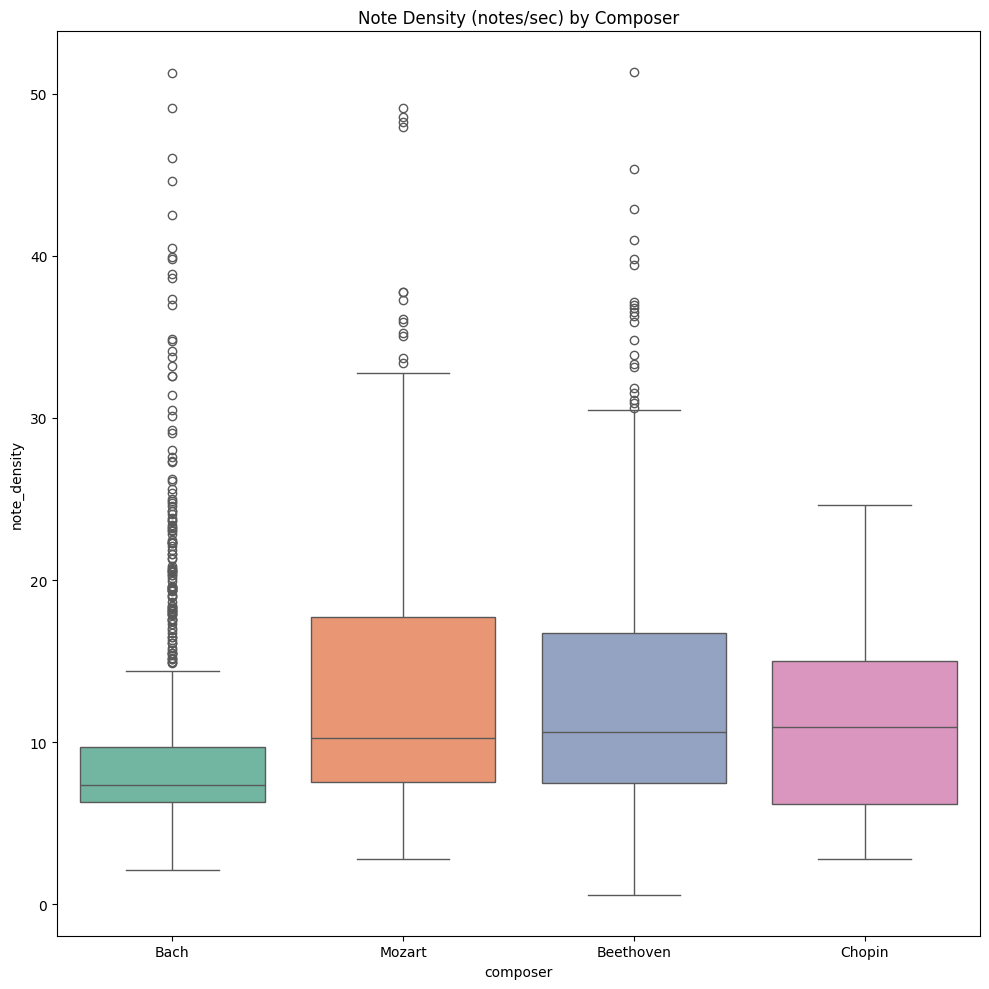

In [ ]:
# Note Density (notes/sec) by Composer
plt.figure(figsize=(10, 10))
sns.boxplot(data=df, x="composer", y="note_density", palette="Set2")
plt.title("Note Density (notes/sec) by Composer")
plt.tight_layout()
plt.show()

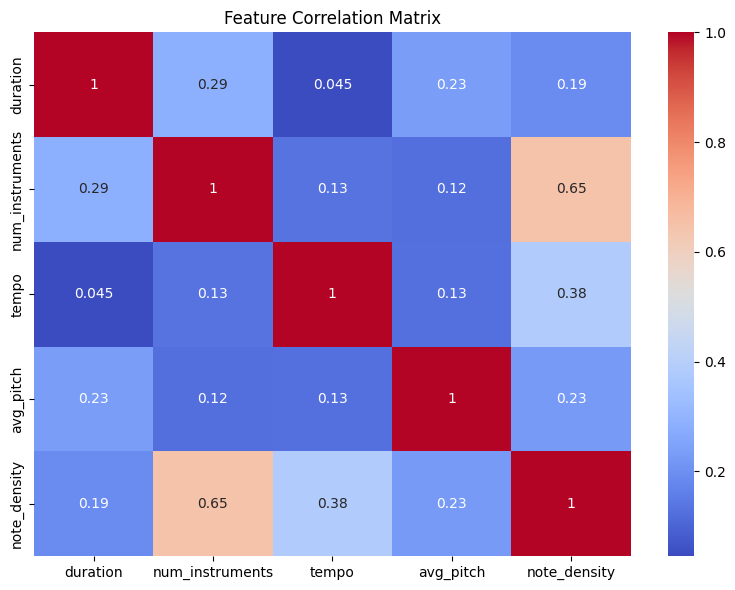

In [ ]:
# Feature Corrleation Metrix
plt.figure(figsize=(8, 6))
sns.heatmap(df.drop(columns=["filename"]).corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

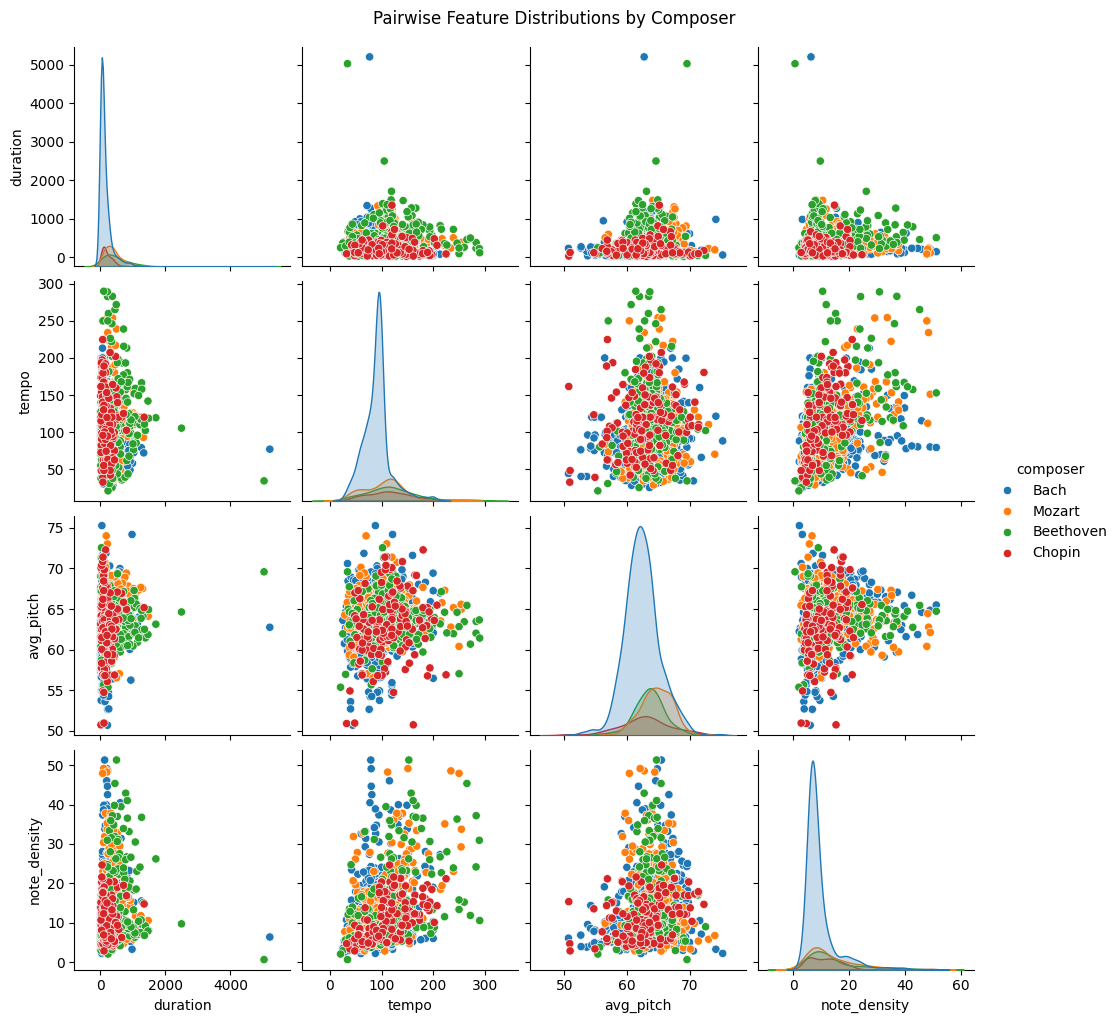

In [ ]:
# How multiple features relate to each other by composer?
sns.pairplot(df, hue="composer", vars=["duration", "tempo", "avg_pitch", "note_density"])
plt.suptitle("Pairwise Feature Distributions by Composer", y=1.02)
plt.show()

In [ ]:
# Feature means + std devs for each composer:
summary_stats = df.groupby("composer")[["duration", "tempo", "avg_pitch", "note_density"]].agg(['mean', 'std'])
print(summary_stats)


             duration                   tempo             avg_pitch            \
                 mean         std        mean        std       mean       std   
composer                                                                        
Bach       156.216898  245.037427   90.273851  26.851171  62.386331  2.839908   
Beethoven  508.445152  492.478649  121.220098  53.837316  63.606823  2.549205   
Chopin     220.828000  184.496352  114.603105  41.796358  62.883127  4.124341   
Mozart     400.837567  273.076911  105.823094  41.877474  64.730406  2.595824   

          note_density            
                  mean       std  
composer                          
Bach          9.437945  6.161045  
Beethoven    14.035460  9.607818  
Chopin       11.211266  5.178630  
Mozart       13.829570  9.191456  
